## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

In [141]:
# Импортируем нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings('ignore')
from mlxtend.data import iris_data
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from typing import Iterable, List, Tuple


Populating the interactive namespace from numpy and matplotlib


## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [9]:
df = pd.read_csv('/Users/alexeysek/Desktop/ML/HW4/data.adult.csv')
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [10]:
# Нам нужно удалить именно объекты, а не столбцы
df = df.dropna()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [18]:
# Вытащим y из датасета
y = pd.DataFrame(df['>50K,<=50K'] == '>50K')
y = y.astype(int)
y.head(5)

,">50K,<=50K"
0,0
1,0
2,0
3,0
4,1


In [19]:
# Вытащим X из датасета
X = df.iloc[:,:-1]
X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


In [20]:
# Только вещественные признаки
X_real = df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X_real.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [66]:
# Let train set be the whole set
Xtrain, ytrain = X_real, y

In [105]:
#KNN

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,50)}

grid = GridSearchCV(knn, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

knn_optimal_n = grid.best_params_

# Нужны, чтобы посчитать доверительный интервал
knn_mean_test = grid.cv_results_["mean_test_score"]
knn_std_test = grid.cv_results_["std_test_score"]

print('knn_optimal_n:', knn_optimal_n)
print('knn_mean_test_score:', knn_mean_test)
print('knn_optimal_n_score:', knn_std_test)

knn_optimal_n: {'n_neighbors': 5}
knn_mean_test_score: [0.61724989 0.63728355 0.63935219 0.64362885 0.64461104 0.64076782
 0.63845829 0.63757354 0.63767501 0.63715813 0.63592794 0.63591173
 0.63490571 0.63372474 0.63134303 0.62999522 0.62942239 0.62941141
 0.62867228 0.6278202  0.62637364 0.62566335 0.62457588 0.62369834
 0.62426826 0.62423763 0.62456154 0.62328996 0.62257801 0.6224057
 0.6219606  0.62263821 0.62178472 0.62130865 0.62030121 0.62061602
 0.61993842 0.62023338 0.61997561 0.61935289 0.61853388 0.6180117
 0.61781943 0.6172397  0.61759762 0.61759451 0.61699142 0.61724845
 0.61705168]
knn_optimal_n_score: [0.00424751 0.00344736 0.00741129 0.00859785 0.00869219 0.00738207
 0.00785523 0.00942954 0.00873703 0.0092293  0.01199678 0.01169016
 0.01113138 0.00891572 0.00855424 0.00842411 0.00782709 0.00841162
 0.00946274 0.0095061  0.00960889 0.00895501 0.0071354  0.00674387
 0.0071998  0.00655975 0.00743834 0.00766987 0.0068376  0.00790373
 0.00812947 0.00846338 0.00902588 0.009139

In [106]:
# DecisionTree

tree = DecisionTreeClassifier()
params = {'max_depth': np.arange(1,50)}

grid = GridSearchCV(tree, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

tree_optimal_n = grid.best_params_
tree_mean_test = grid.cv_results_["mean_test_score"]
tree_std_test = grid.cv_results_["std_test_score"]

print('tree_optimal_n:', tree_optimal_n)
print('tree_mean_test_score:', tree_mean_test)
print('tree_optimal_n_score:', tree_std_test)

tree_optimal_n: {'max_depth': 7}
tree_mean_test_score: [0.59301167 0.71975313 0.79314635 0.81147086 0.82952424 0.83991076
 0.84509024 0.84276106 0.83690643 0.82957368 0.8215494  0.811743
 0.80330149 0.79115991 0.77671231 0.76729781 0.757289   0.74540568
 0.73946383 0.73133264 0.72614698 0.71742762 0.71419794 0.7075406
 0.70228038 0.70312416 0.69960883 0.69492186 0.69363201 0.68988865
 0.68968291 0.68612138 0.68585358 0.68465763 0.68538185 0.68462357
 0.68361129 0.68414826 0.68550258 0.68242422 0.68548683 0.68229302
 0.68238928 0.68301755 0.68499045 0.68228399 0.68232162 0.6832375
 0.68360569]
tree_optimal_n_score: [0.00401423 0.00575177 0.0045185  0.00236133 0.00372814 0.00311308
 0.00435895 0.0036545  0.00520868 0.00342855 0.00326748 0.00416275
 0.0036365  0.00353359 0.00542875 0.00385687 0.0054996  0.00576159
 0.00559241 0.00841802 0.00652303 0.00644816 0.00409851 0.00452361
 0.0063936  0.00581798 0.00827446 0.00578873 0.0073115  0.00532301
 0.00904951 0.01123507 0.00793384 0.0083556

In [107]:
# SGD Linear Classifier

sgd = SGDClassifier(max_iter=1000)
sgd_params = {'loss': ['hinge', 'log', 'modified_huber',
                       'squared_hinge', 'perceptron', 'huber',
                       'epsilon_insensitive', 'squared_epsilon_insensitive']}

grid = GridSearchCV(sgd, sgd_params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

sgd_optimal_n = grid.best_params_
sgd_mean_test = grid.cv_results_["mean_test_score"]
sgd_std_test = grid.cv_results_["std_test_score"]

print('sgd_optimal_n:', sgd_optimal_n)
print('sgd_mean_test_score:', sgd_mean_test)
print('sgd_optimal_n_score:', sgd_std_test)

sgd_optimal_n: {'loss': 'squared_hinge'}
sgd_mean_test_score: [0.61250364 0.60608286 0.59528072 0.61417602 0.61109223 0.49484243
 0.50237621 0.49025944]
sgd_optimal_n_score: [0.02770021 0.02103667 0.0123583  0.02820483 0.02713739 0.01975655
 0.01483046 0.0171785 ]


In [108]:
# Построим доверительные интервалы

low_knn = knn_mean_test - 1.96 * knn_std_test
top_knn = knn_mean_test + 1.96 * knn_std_test

low_tree = tree_mean_test - 1.96 * tree_std_test
top_tree = tree_mean_test + 1.96 * tree_std_test

error_sgd = 1.96 * sgd_std_test

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

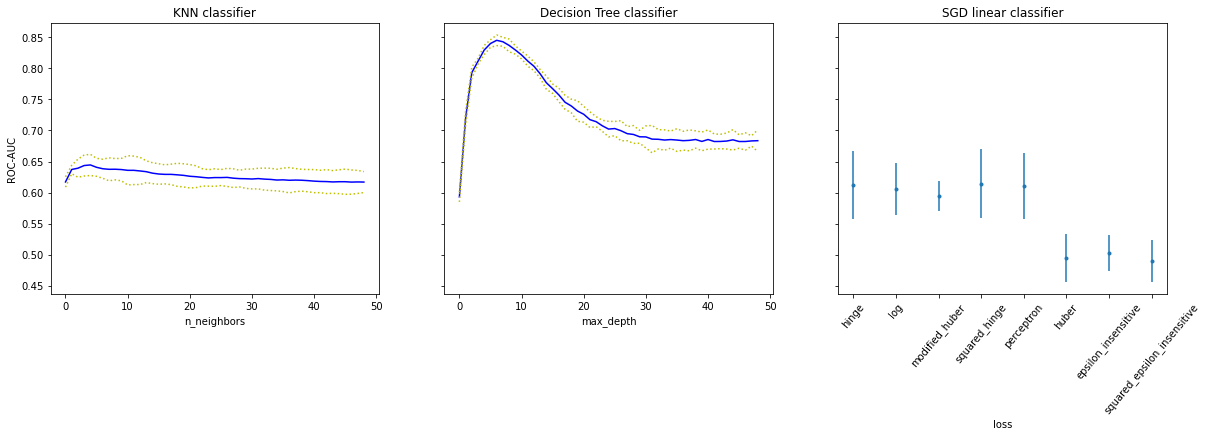

In [115]:
# Построим графики
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,5))

# KNN
axes[0].plot(knn_mean_test, color='b')
axes[0].plot(low_knn, linestyle='dotted', color='y')
axes[0].plot(top_knn, linestyle='dotted', color='y')
# Описание для графика
axes[0].set_title('KNN classifier')
axes[0].set_xlabel("n_neighbors")
axes[0].set_ylabel("ROC-AUC")

# Tree
axes[1].plot(tree_mean_test, color='b')
axes[1].plot(low_tree, linestyle='dotted', color='y')
axes[1].plot(top_tree, linestyle='dotted', color='y')
# Описание для графика
axes[1].set_title('Decision Tree classifier')
axes[1].set_xlabel("max_depth")


# SGD
axes[2].errorbar(sgd_params["loss"], sgd_mean_test, yerr = error_sgd, linestyle = '', marker='.')
# Описание для графика
axes[2].set_title('SGD linear classifier')
axes[2].set_xlabel("loss")
plt.xticks(rotation = 50)

Что вы можете сказать о получившихся графиках?

**Выводы:** 

Наилучшая модель - решающая дерева с максимальной глубиной 7, если мы рассматриваем критерий ROC-AUC
Если мы увеличим глубину - средняя метрика качества на кросс-валидации будет падать (переобучение)

Похожу ситуацию мы видим и для KNN классификатора, для которого оптимальное число соседей - 4, при их увеличении метрика качества на кросс-валидации так же будет падать (переобучение)


**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

Text(0, 0.5, 'Mean ROC-AUC')

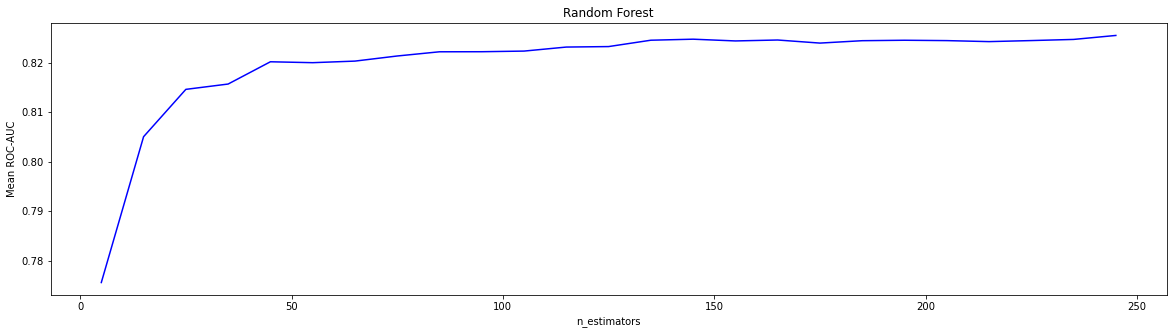

In [120]:
# Random Forest

# Обучим один лес с максимальным интересным количеством деревьев
rf = RandomForestClassifier()
rf_params = {'n_estimators' : range(5, 250, 10)}
grid = GridSearchCV(rf, rf_params, scoring = 'roc_auc')
grid.fit(X_real, y)

# Построим ROC-AUC в зависимости от количества деревьев
rf_mean_test = grid.cv_results_["mean_test_score"]
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(rf_params["n_estimators"], rf_mean_test, color='b')
# Описание для графика
ax.set_title('Random Forest');
ax.set_xlabel("n_estimators")
ax.set_ylabel("Mean ROC-AUC")

**Выводы:** Так сказать, "на глаз" после 150 деревьев метрика ROC-AUC стабилизируется

Поэтому я буду считать 150 оптимальным количеством деревьев для random forest

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

Text(0, 0.5, 'ROC-AUC')

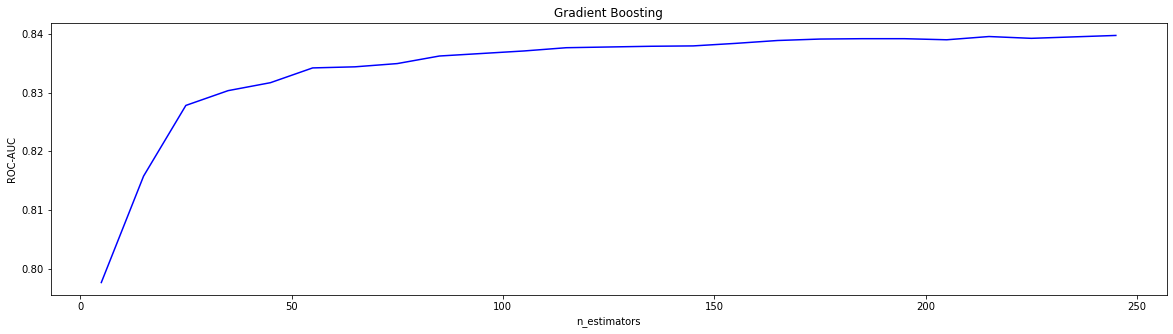

In [129]:
# Gradient Boosting

gb = GradientBoostingClassifier()
gb_params = {'n_estimators' : range(5, 250, 10)}
grid = GridSearchCV(gb, gb_params)
grid.fit(X_real, y)
grid.n_splits_=5

# Построим ROC-AUC в зависимости от количества деревьев
gb_mean_test = grid.cv_results_["mean_test_score"]
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(gb_params["n_estimators"], gb_mean_test, color='b')
# Описание для графика
ax.set_title('Gradient Boosting');
ax.set_xlabel("n_estimators")
ax.set_ylabel("ROC-AUC")

**Выводы:** Здесь задание не очень понятно, обычно мы смотрели на ROC-AUC, а тут на loss, я сделал не loss, а ROC-AUC, как и для других пунктов

Качество растет по мере увеличения деревьев, но растет и переобучение

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Text(0, 0.5, '# of observations')

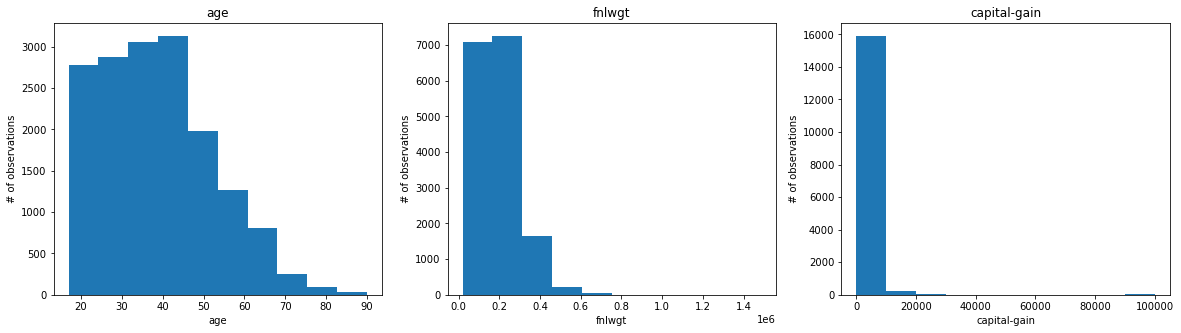

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(df['age'])
axes[0].set_title('age')
axes[0].set_xlabel('age')
axes[0].set_ylabel('# of observations')

axes[1].hist(df['fnlwgt'])
axes[1].set_title('fnlwgt')
axes[1].set_xlabel('fnlwgt')
axes[1].set_ylabel('# of observations')

axes[2].hist(df['capital-gain'])
axes[2].set_title('capital-gain')
axes[2].set_xlabel('capital-gain')
axes[2].set_ylabel('# of observations')

**Выводы:** Так как размерности разные у признаков (age от 0 до 90; fnlwgt от 0 до 1; capital-gain от 0 до 20000), это может влиять на работу линейных классификаторов, например, SGD linear classifier или KNN (вклад в расстояние между соседями некоторых прищнаков больше, чем других). Поэтому для этих алгоритмов необходимо масштабировать данные, чтобы улучшить результаты!

В это же время решающие деревья, случайный лес и градиентный бустинг можно применять и без масштабирования признаков, потому что на них не влияет масштаб признаков.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [148]:
# Масштабируем все признаки
scaler = MinMaxScaler()
cols = X_real.columns.values
X_real_new = pd.DataFrame(scaler.fit_transform(X_real))
X_real_new.columns = cols
X_real_new

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.232877,0.181207,0.533333,0.005940,0.000000,0.602041
1,0.315068,0.116683,0.600000,0.000000,0.000000,0.397959
2,0.260274,0.108200,0.800000,0.000000,0.000000,0.397959
3,0.068493,0.112907,0.600000,0.000000,0.000000,0.295918
4,0.410959,0.088984,0.800000,0.150242,0.000000,0.397959
...,...,...,...,...,...,...
16275,0.109589,0.338074,0.800000,0.000000,0.000000,0.397959
16276,0.205479,0.128542,0.800000,0.150242,0.000000,0.448980
16277,0.136986,0.058110,0.800000,0.000000,0.000000,0.397959
16278,0.575342,0.170191,0.533333,0.000000,0.000000,0.397959


In [149]:
# Let train set be the whole set
Xtrain, ytrain = X_real_new, y

In [150]:
#KNN

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,50)}

grid = GridSearchCV(knn, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

knn_optimal_n = grid.best_params_

# Нужны, чтобы посчитать доверительный интервал
knn_mean_test = grid.cv_results_["mean_test_score"]
knn_std_test = grid.cv_results_["std_test_score"]

print('knn_optimal_n:', knn_optimal_n)
print('knn_mean_test_score:', knn_mean_test)
print('knn_optimal_n_score:', knn_std_test)

knn_optimal_n: {'n_neighbors': 43}
knn_mean_test_score: [0.66352092 0.71694622 0.7439135  0.76534096 0.77780723 0.78713744
 0.79457494 0.80176027 0.80633344 0.81104591 0.8146429  0.81790179
 0.8197002  0.82128162 0.82180753 0.82169758 0.82215971 0.82303336
 0.82357146 0.82438245 0.82509638 0.8253243  0.8261997  0.82655574
 0.82663543 0.82755671 0.82825933 0.82856642 0.82816225 0.82896359
 0.82948239 0.83022928 0.83015215 0.83033299 0.83040632 0.83051162
 0.83028863 0.83048016 0.83065368 0.83090239 0.83098254 0.83124195
 0.83160084 0.83158766 0.83137749 0.83117805 0.83154379 0.83136111
 0.83124468]
knn_optimal_n_score: [0.00496601 0.00611748 0.00668367 0.00804321 0.0053261  0.00532687
 0.00434968 0.00561004 0.00541684 0.00479407 0.00397882 0.00438263
 0.00415433 0.00340627 0.00348869 0.00368628 0.0031321  0.00299618
 0.00325983 0.0034617  0.00320142 0.00332473 0.00367979 0.00398181
 0.00414545 0.0033713  0.00355114 0.00367233 0.00390057 0.00406689
 0.00429919 0.00444288 0.00460435 0.004

In [151]:
# DecisionTree

tree = DecisionTreeClassifier()
params = {'max_depth': np.arange(1,50)}

grid = GridSearchCV(tree, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

tree_optimal_n = grid.best_params_
tree_mean_test = grid.cv_results_["mean_test_score"]
tree_std_test = grid.cv_results_["std_test_score"]

print('tree_optimal_n:', tree_optimal_n)
print('tree_mean_test_score:', tree_mean_test)
print('tree_optimal_n_score:', tree_std_test)

tree_optimal_n: {'max_depth': 7}
tree_mean_test_score: [0.59301167 0.71975313 0.79314635 0.81147086 0.82969066 0.83965757
 0.84498469 0.84283767 0.8370541  0.83015248 0.82214732 0.81171769
 0.80312582 0.79053655 0.77818644 0.76660544 0.75498784 0.74561693
 0.73627242 0.7320272  0.72370954 0.71932148 0.71333004 0.70944392
 0.7041254  0.69951371 0.70070416 0.69383003 0.69306009 0.69192585
 0.68972825 0.68639341 0.68819791 0.68721306 0.68417842 0.68517493
 0.68445283 0.68081715 0.68244545 0.68530985 0.68342741 0.68276396
 0.68514802 0.68405235 0.68401811 0.68284771 0.68412355 0.68521702
 0.68502204]
tree_optimal_n_score: [0.00401423 0.00575177 0.0045185  0.00236133 0.00354818 0.00321182
 0.00426636 0.0035332  0.0036551  0.00302299 0.00259162 0.00287947
 0.00373964 0.00257689 0.0060258  0.0067016  0.00495783 0.00650132
 0.00492224 0.00649936 0.00371032 0.00404957 0.00430724 0.00208507
 0.00521635 0.00630076 0.00762379 0.00476784 0.00948877 0.00847245
 0.00815882 0.00949026 0.00969283 0.008

In [152]:
# SGD Linear Classifier

sgd = SGDClassifier(max_iter=1000)
sgd_params = {'loss': ['hinge', 'log', 'modified_huber',
                       'squared_hinge', 'perceptron', 'huber',
                       'epsilon_insensitive', 'squared_epsilon_insensitive']}

grid = GridSearchCV(sgd, sgd_params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

sgd_optimal_n = grid.best_params_
sgd_mean_test = grid.cv_results_["mean_test_score"]
sgd_std_test = grid.cv_results_["std_test_score"]

print('sgd_optimal_n:', sgd_optimal_n)
print('sgd_mean_test_score:', sgd_mean_test)
print('sgd_optimal_n_score:', sgd_std_test)

sgd_optimal_n: {'loss': 'modified_huber'}
sgd_mean_test_score: [0.82361853 0.82414679 0.82871341 0.81392654 0.82229788 0.81430683
 0.81560411 0.81738706]
sgd_optimal_n_score: [0.00309667 0.00455239 0.00404324 0.00631071 0.0053019  0.0023783
 0.00168333 0.00395287]


In [154]:
# Random Forest

# Обучим один лес с максимальным интересным количеством деревьев
rf = RandomForestClassifier()
rf_params = {'n_estimators' : range(5, 250, 10)}
grid = GridSearchCV(rf, rf_params, scoring = 'roc_auc')
grid.fit(X_real, y)

rf_mean_test = grid.cv_results_["mean_test_score"]

In [156]:
rf_mean_test

array([0.77905473, 0.80709841, 0.81103148, 0.81676715, 0.81950348,
       0.82120182, 0.82147214, 0.82208557, 0.82099034, 0.82319375,
       0.82264967, 0.82329105, 0.82340289, 0.82480726, 0.82451981,
       0.82444901, 0.82463838, 0.82393524, 0.82438831, 0.82418649,
       0.82430047, 0.82496363, 0.82457218, 0.82562293, 0.8254702 ])

In [153]:
# Gradient Boosting

gb = GradientBoostingClassifier()
gb_params = {'n_estimators' : range(5, 250, 10)}
grid = GridSearchCV(gb, gb_params)
grid.fit(X_real, y)
grid.n_splits_=5

gb_mean_test = grid.cv_results_["mean_test_score"]

In [155]:
gb_mean_test

array([0.79766585, 0.81578624, 0.82782555, 0.83034398, 0.83175676,
       0.83421376, 0.83439803, 0.83495086, 0.83624079, 0.83667076,
       0.83710074, 0.83765356, 0.83777641, 0.83789926, 0.83796069,
       0.83839066, 0.83888206, 0.83912776, 0.83925061, 0.83918919,
       0.83906634, 0.83943489, 0.83925061, 0.83949631, 0.83980344])

Изменилось ли качество у некоторых алгоритмов?

**Выводы:**
- KNN - изменился гиперпараметр количества соседей, стал 43 -> качество изменилось (улучшилось)
- SGD linear - изменился гиперпараметр 'loss', стал 'modified_huber -> качество изменилось (улучшилось)
- Decision tree - не поменялся выбор гиперпараметра -> нет изменений
- Random forest - нет изменений
- Gradient boosting - нет изменений

Это подтверждает выводы, сделанные в предыдущем пункте

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [ ]:
#your code here

In [158]:
#KNN

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,50), 'metric':['euclidean', 'manhattan', 'chebyshev']}

grid = GridSearchCV(knn, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

print('KNN')
print('best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

KNN
best parameters: {'metric': 'manhattan', 'n_neighbors': 49}
best score: 0.8328625702906587


In [159]:
# DecisionTree

tree = DecisionTreeClassifier()
params = {'max_depth': np.arange(1,50), 'criterion':["gini", "entropy"]}

grid = GridSearchCV(tree, params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

print('Decision tree')
print('best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

Decision tree
best parameters: {'criterion': 'entropy', 'max_depth': 8}
best score: 0.8451309219178953


In [160]:
# SGD Linear Classifier

sgd = SGDClassifier(max_iter=1000)
sgd_params = {'loss': ['hinge', 'log', 'modified_huber',
                       'squared_hinge', 'perceptron', 'huber',
                       'epsilon_insensitive', 'squared_epsilon_insensitive'],'penalty': ['l2', 'l1', 'elasticnet']}

grid = GridSearchCV(sgd, sgd_params, scoring='roc_auc')
grid.n_splits_=5
grid.fit(Xtrain, ytrain)

print('SGD')
print('best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

SGD
best parameters: {'loss': 'log', 'penalty': 'l1'}
best score: 0.8289538466578554


In [162]:
# Random Forest

# Обучим один лес с максимальным интересным количеством деревьев
rf = RandomForestClassifier(n_estimators=150)
rf_params = {"max_features": ['auto', 'sqrt', 'log2'], 'criterion':["gini", "entropy"]}
grid = GridSearchCV(rf, rf_params, scoring = 'roc_auc')
grid.fit(X_real, y)

rf_mean_test = grid.cv_results_["mean_test_score"]

print('Random Forest')
print('best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

Random Forest
best parameters: {'criterion': 'entropy', 'max_features': 'log2'}
best score: 0.8251934321529216


In [166]:
# Gradient Boosting

# Задачу 4 я не очень понял из-за формулировки, поэтому здесь буду использовать 50 (просто рандомно выбрал)
gb = GradientBoostingClassifier(n_estimators=50)
gb_params = {"max_features": ['auto', 'sqrt', 'log2'], 'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']}
grid = GridSearchCV(gb, gb_params)
grid.fit(X_real, y)
grid.n_splits_=5

gb_mean_test = grid.cv_results_["mean_test_score"]

print('Gradient Boosting')
print('best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

Gradient Boosting
best parameters: {'criterion': 'mse', 'max_features': 'auto'}
best score: 0.8329238329238329


Какой из алгоритмов имеет наилучшее качество? 

**Выводы:** Алгоритм решающее дерево с гиперпараметрами 'criterion': 'entropy', 'max_depth': 8 дал нам наилучшее качество best score = 0.8451

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [184]:
# Способ измерения времени работы алгоритма взял со stackoverflow: https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
import time


# KNN
start_time = time.time()

knn = KNeighborsClassifier(metric='manhattan', n_neighbors=49)
knn.fit(X_real_new, y)

print("KNN:", "--- %s seconds ---" % (time.time() - start_time))



# SGD
start_time = time.time()

sgd = SGDClassifier(penalty = 'l1', loss='log')
sgd.fit(X_real_new, y)

print("SGD:", "--- %s seconds ---" % (time.time() - start_time))



# Decision Tree
start_time = time.time()

tree = DecisionTreeClassifier(criterion='entropy', max_depth=8)
tree.fit(X_real_new, y)

print("Decision Tree:", "--- %s seconds ---" % (time.time() - start_time))



# Random Forest
start_time = time.time()

rf = RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators = 150)
rf.fit(X_real_new, y)

print("Random Forest:", "--- %s seconds ---" % (time.time() - start_time))



# Gradient Boosting
start_time = time.time()

gb = GradientBoostingClassifier(n_estimators=50, criterion='mse', max_features='auto')
gb.fit(X_real_new, y)

print("Gradient Boosting:", "--- %s seconds ---" % (time.time() - start_time))

KNN: --- 0.058281898498535156 seconds ---
SGD: --- 0.025089025497436523 seconds ---
Decision Tree: --- 0.02643108367919922 seconds ---
Random Forest: --- 1.374450922012329 seconds ---
Gradient Boosting: --- 0.4866659641265869 seconds ---


**Выводы:** Дольше всего обучается случайный лес, это ожидаемо, ведь случайный лес состоит из нескольких деревьев (классификаторов). Градиентный бустинг тоже обучает несколько классификаторов, но работает немного быстрее, хотя все равно существенно дольше, чем единичные классификаторы (KNN, SGD, Decision Tree)

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [180]:
# Все предикторы, включая категориальные, хранятся в переменной X
# Давайте применим к ней функцию pandas.get_dummies
X_all_new = pd.get_dummies(X)
X_all_new.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,284843,9,594,0,60,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,40,190290,10,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,36,177858,13,0,0,40,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
3,22,184756,10,0,0,30,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,47,149700,13,15024,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [182]:
X_real.columns.values

array(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'], dtype=object)

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [183]:
# Масштабируем все вещественные признаки
scaler = MinMaxScaler()
old_cols = X_all_new.columns.values
cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
X_all_new[cols] = pd.DataFrame(scaler.fit_transform(X_all_new[cols]))
X_all_new.columns = old_cols
X_all_new.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.232877,0.181207,0.533333,0.005940,0.0,0.602041,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,0.315068,0.116683,0.600000,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0.260274,0.108200,0.800000,0.000000,0.0,0.397959,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
3,0.068493,0.112907,0.600000,0.000000,0.0,0.295918,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0.410959,0.088984,0.800000,0.150242,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [185]:
# Возьмем все классификаторы из предыдущего пункта
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=49)
sgd = SGDClassifier(penalty = 'l1', loss='log')
tree = DecisionTreeClassifier(criterion='entropy', max_depth=8)
rf = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators = 150)
gb = GradientBoostingClassifier(n_estimators=50, criterion='mse', max_features='auto')

In [192]:
# С категориальными переменными
from sklearn.model_selection import cross_val_score
print("KNN with categorical variables:", cross_val_score(knn, X_all_new, y, scoring='roc_auc').mean())
print("SGD with categorical variables:", cross_val_score(sgd, X_all_new, y, scoring='roc_auc').mean())
print("Decision Tree with categorical variables:", cross_val_score(tree, X_all_new, y, scoring='roc_auc').mean())
print("Random Forest with categorical variables:", cross_val_score(rf, X_all_new, y, scoring='roc_auc').mean())
print("Gradient Boosting with categorical variables:", cross_val_score(gb, X_all_new, y, scoring='roc_auc').mean())

KNN with categorical variables: 0.881856561233404
SGD with categorical variables: 0.9048797165442053
Decision Tree with categorical variables: 0.8941099984185653
Random Forest with categorical variables: 0.9028482310149697
Gradient Boosting with categorical variables: 0.9149283857436223


In [191]:
# Без категориальных переменных
print("KNN without categorical variables:", cross_val_score(knn, X_real, y, scoring='roc_auc').mean())
print("SGD without categorical variables:", cross_val_score(sgd, X_real, y, scoring='roc_auc').mean())
print("Decision Tree without categorical variables:", cross_val_score(tree, X_real, y, scoring='roc_auc').mean())
print("Random Forest without categorical variables:", cross_val_score(rf, X_real, y, scoring='roc_auc').mean())
print("Gradient Boosting without categorical variables:", cross_val_score(gb, X_real, y, scoring='roc_auc').mean())

KNN without categorical variables: 0.621544922541589
SGD without categorical variables: 0.6217257178623872
Decision Tree without categorical variables: 0.8447551956649315
Random Forest without categorical variables: 0.8238486791953207
Gradient Boosting without categorical variables: 0.862010363267388


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

**Выводы:** добавление категориальных переменных дало существенный прирост качества для всех алгоритмов

Да, теперь лучший алгоритм отличается от предыдущего пункта - здесь это градиентный бустинг

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [194]:
# Накинем полиномиальных признаков второй степени (только на исходные числовые признаки)
import warnings
warnings.filterwarnings('ignore')

poly_vars = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']

poly = PolynomialFeatures(degree=2)

for var in poly_vars:
    p = pd.DataFrame(poly.fit_transform(np.array(X_all_new[var]).reshape(-1, 1)))
    p = p.iloc[:,-1]
    X_all_new[var + '^2'] = p

X_all_new.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,race_Other,race_White,sex_Female,sex_Male,age^2,fnlwgt^2,education-num^2,capital-gain^2,capital-loss^2,hours-per-week^2
0,0.232877,0.181207,0.533333,0.005940,0.0,0.602041,0,0,1,0,...,0,0,0,1,0.054232,0.032836,0.284444,0.000035,0.0,0.362453
1,0.315068,0.116683,0.600000,0.000000,0.0,0.397959,0,0,0,0,...,0,1,0,1,0.099268,0.013615,0.360000,0.000000,0.0,0.158372
2,0.260274,0.108200,0.800000,0.000000,0.0,0.397959,0,0,1,0,...,0,1,0,1,0.067743,0.011707,0.640000,0.000000,0.0,0.158372
3,0.068493,0.112907,0.600000,0.000000,0.0,0.295918,0,0,0,0,...,0,1,1,0,0.004691,0.012748,0.360000,0.000000,0.0,0.087568
4,0.410959,0.088984,0.800000,0.150242,0.0,0.397959,0,0,0,0,...,0,1,0,1,0.168887,0.007918,0.640000,0.022573,0.0,0.158372


In [209]:
# Фильтрационные методы
from sklearn.feature_selection import mutual_info_classif

res = mutual_info_classif(X_all_new, y)
res

array([6.77036536e-02, 1.78322153e-02, 6.80333693e-02, 7.74872665e-02,
       3.57423709e-02, 3.55573573e-02, 2.89919418e-03, 1.18186267e-03,
       0.00000000e+00, 0.00000000e+00, 4.60575927e-03, 5.33638609e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.62857932e-03,
       5.03913152e-03, 0.00000000e+00, 0.00000000e+00, 4.60514186e-04,
       0.00000000e+00, 6.92870177e-03, 3.50571575e-03, 0.00000000e+00,
       7.77423228e-03, 3.98123927e-03, 1.03738634e-02, 1.68053990e-02,
       2.31241676e-05, 9.94157039e-03, 0.00000000e+00, 9.71822635e-03,
       0.00000000e+00, 1.13556001e-01, 1.83257999e-03, 5.81978871e-02,
       6.54827434e-03, 0.00000000e+00, 1.97359409e-03, 4.85746412e-03,
       9.87527751e-04, 0.00000000e+00, 1.98543193e-02, 9.98637777e-04,
       3.82272177e-03, 1.04780448e-03, 2.11861804e-02, 5.52073516e-03,
       1.39328829e-02, 3.79074080e-04, 0.00000000e+00, 3.38403408e-03,
       3.03879449e-03, 8.10564679e-02, 1.82615617e-02, 1.41493549e-03,
      

**Почему сделал задание частично?**
- Добавил полиномиальные признаки порядка 2, они добавлены в общий датасет с категориальными признаками (но полиномиальные накидывал только для числовых), но реализацию следующих шагов я не до конца осознал
- Я понимаю, как отфильтровать k лучших признаков (sklearn.feature_selection.SelectKBest), но совсем не понимаю, как сделать кросс-валидацию одновременно для поиска оптимального k и поиска оптимальных гиперпараметров модели - это не дает мне решить подпункты про фильтрационные методы, жадные отбор и встроенный в алгоритм метод

In [ ]:
# Жадный отбор RFE



In [ ]:
# Встроенный в модель метод
# Вероятно здесь стоит использовать L1 или L0 регуляризацию, которая зануляет коэффициенты некоторых предикторов


## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [233]:
# Возьмем классификаторы из предыдущих пунктов
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=49)
sgd = SGDClassifier(penalty = 'l1', loss='log')

In [272]:
# Пройдемся циклом по каждому альфа от 0 до 1 (я взял 50 значений)
# Будем сохранять средний AUC ROC для каждого альфа (для каждой итерации)
mean_AUC_ROC = []

# 5-fold CV как указано в условии
kf = KFold(5)

for alpha in tqdm(linspace(0, 1, 50)):
    
    AUC_ROC = []
    
    for train_index, test_index in kf.split(X_all_new):
        
        X_train, X_test = X_all_new.iloc[train_index,:], X_all_new.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

        knn.fit(X_train, y_train)
        sgd.fit(X_train, y_train)

        # берем [:,1], чтобы брать вероятности положительного класса   
        knn_pred = knn.predict_proba(X_test)[:,1]
        sgd_pred = sgd.predict_proba(X_test)[:,1]
        
        # посчитаем средневзвешенный прогноз двух алгоритмов        
        y_pred_prob = alpha * knn_pred + (1-alpha) * sgd_pred
        
        AUC_ROC.append(roc_auc_score(y_test, y_pred_prob))
        
    mean_AUC_ROC.append(np.mean(AUC_ROC))

mean_AUC_ROC

100%|██████████| 50/50 [15:06<00:00, 18.13s/it]


[0.9101490146245901,
 0.91051447246188,
 0.9101214828059849,
 0.9109360647877809,
 0.910836527835318,
 0.9109970285533336,
 0.9113913591245945,
 0.9112092205341178,
 0.9112059241259335,
 0.9108043217332986,
 0.9107773331199069,
 0.9108630273878997,
 0.9108637053849812,
 0.9102510504546218,
 0.9104571580674288,
 0.9100731294267808,
 0.9101012117046305,
 0.9092457155105818,
 0.9095535041889162,
 0.9094982838143378,
 0.9089589565313567,
 0.9086225095516417,
 0.9083043937741235,
 0.9077143327853758,
 0.9079069024556515,
 0.9073394237141927,
 0.9066582575083133,
 0.9058617859372585,
 0.9052581215991161,
 0.9044392346371171,
 0.9039285279314324,
 0.9038420973911752,
 0.9026415345133723,
 0.9021234949152259,
 0.9010090847547293,
 0.9003561021870208,
 0.8994309584521781,
 0.8986244386968464,
 0.8973626396065025,
 0.8963396751336805,
 0.8949208988095657,
 0.8939320126311721,
 0.8926133753999231,
 0.8914189897093603,
 0.8901194706727935,
 0.8886589595524992,
 0.8874056438641714,
 0.8859318958186

In [273]:
mean_AUC_ROC = np.array(mean_AUC_ROC)
# Коряво, конечно, но не хотел запариваться и делать красиво расчет оптимпльного alpha
optimal_alpha = (1-0)/50 * mean_AUC_ROC.argmax()
optimal_alpha

alphas = np.linspace(0, 1, 50)

Text(0.5, 1.0, 'ROC-AUC depending on Alpha')

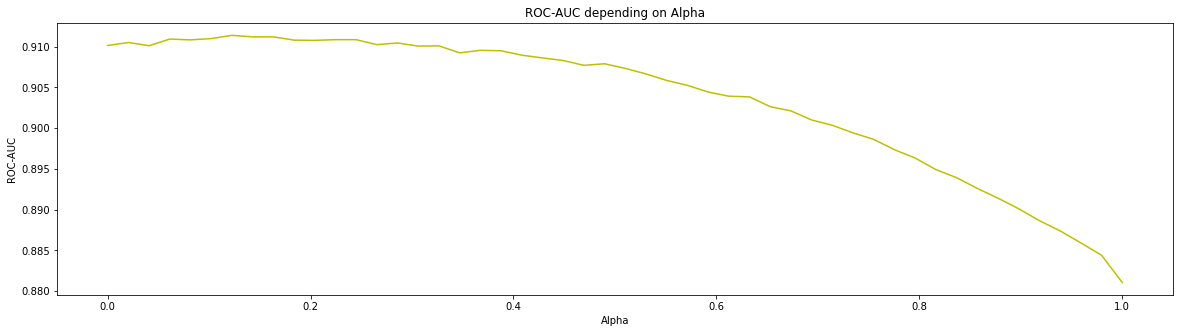

In [274]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(alphas, mean_AUC_ROC, color='y')

ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Alpha')

ax.set_title('ROC-AUC depending on Alpha')

In [275]:
print("Максимальное значение mean_AUC_ROC:",max(mean_AUC_ROC), "оно достигается при alpha", optimal_alpha)

Максимальное значение mean_AUC_ROC: 0.9113913591245945 оно достигается при alpha 0.12


**Выводы:** Я обучал модель c категориальными переменными, это было довольно долго. Относительно результатов отдельно SGD и KNN, результаты при смешивании двух моделей оказались немного лучше: 0.91 mean_ROC_AUC после смешивания моделей vs 0.90 и 0.88 mean_ROC_AUC до смешивания

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [276]:
# Давайте обучим наш смешанный алгоритм с оптимальным альфа

AUC_ROC_list = []
kf = KFold(5)

for train_index, test_index in kf.split(X_real_new):
    
    X_train, X_test = X_all_new.iloc[train_index,:], X_all_new.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    # берем [:,1], чтобы брать вероятности положительного класса   
    knn_pred = knn.predict_proba(X_test)[:,1]
    sgd_pred = sgd.predict_proba(X_test)[:,1]

    # посчитаем средневзвешенный прогноз двух алгоритмов        
    y_pred_prob = optimal_alpha * knn_pred + (1-optimal_alpha) * sgd_pred
    AUC_ROC_list.append(roc_auc_score(y_test, y_pred_prob))

In [294]:
# Для остальных алгоритмов тоже посчитаем ROC-AUC (на самом деле считали в предыдущих пунктах)
cv_ROC_AUC_knn = cross_val_score(knn, X_all_new, y, scoring='roc_auc')
cv_ROC_AUC_sgd = cross_val_score(sgd, X_all_new, y, scoring='roc_auc')
cv_ROC_AUC_tree = cross_val_score(tree, X_all_new, y, scoring='roc_auc')
cv_ROC_AUC_rf = cross_val_score(rf, X_all_new, y, scoring='roc_auc')
cv_ROC_AUC_gb = cross_val_score(gb, X_all_new, y, scoring='roc_auc')

Text(0.5, 1.0, 'ROC_AUC comparison')

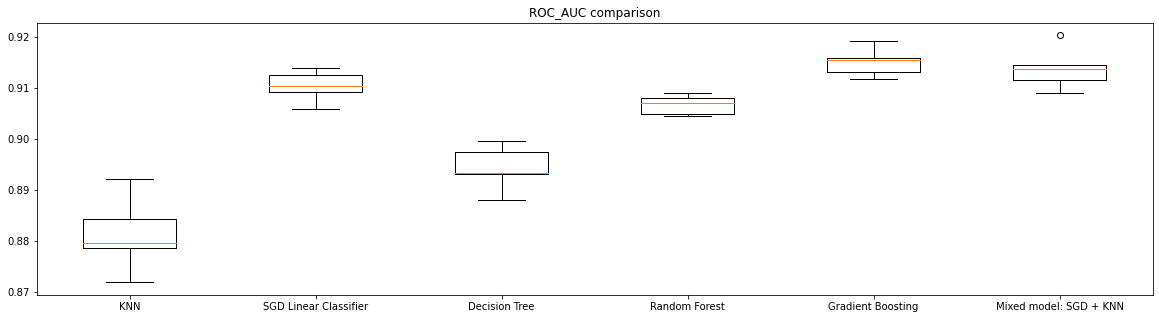

In [297]:
# Используем функцию boxplot для этого графика
fig, ax = plt.subplots(figsize=(20,5))
ax.boxplot([cv_ROC_AUC_knn, cv_ROC_AUC_sgd, cv_ROC_AUC_tree, cv_ROC_AUC_rf, cv_ROC_AUC_gb, AUC_ROC_list])
ax.set_xticklabels(['KNN', 
                    'SGD Linear Classifier', 
                    'Decision Tree',
                    'Random Forest', 
                    'Gradient Boosting',
                    'Mixed model: SGD + KNN'])

ax.set_title("ROC_AUC comparison")

**Выводы:** 

 - KNN: показал худшее качество, особенно плохо работает, когда признаки не масштабированы. Гиперпараметры: количество соседей, метрика
 - SGDClassifier: довольно неплохое качество, учитывая, что это не композиция нескольких алгоритмов, а один, качество стало лучше после масштабирования признаков. Гиперпараметры: loss, penalty
 - DecisonTree: хорошо работает, если данные не масштабированы, но после масштабирования стал уступать предыдущим алгоритмам. Гиперпараметры: глубина дерева, критерий разбиения
 - RandomForest: показывает хорошие результаты, относительно одного дерева, но при этом сушественно больше времени требуется на его обучение. Гиперпараметры: критерий разбиения в деревьях, max_features (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting: судя по финальному графика - этот алгоритм является наилучшим для решения задачи классификации на представленных данных. Гиперпараметры: критерий разбиения в деревьях, max_features (при фиксированном количестве деревьев, найденном ранее) 
 - Mixed KNN + SGD: эта модель получилась после объединения двух моделей KNN и SGD (их средневзвешенная оценка, где оптимальные веса подбирались перебором) и показала отличные результаты